In [231]:
import re
import os
import glob
import json
import sqlite3
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from typing import List, Dict
from kics_qis4_scenario import SmithWilsonYTM, SmithWilson_ALPHA, Cont2Discrete, SmithWilson

from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [33]:
DOWNLOAD_PATH = rf'C:\Users\{os.environ["USERNAME"]}\Downloads'
TENOR_MAP = {'3월': 0.25, '6월': 0.5, '9월': 0.75, '1년': 1.0, '1년6월': 1.5, '2년': 2., '2년6월': 2.5, '3년': 3., '4년': 4., '5년': 5., '7년': 7., '10년': 10., '15년': 15., '20년': 20., '30년': 30., '50년': 50.}

In [88]:
# fx_tenor, fx_setting
FILENAME = "data/FSS_IFRS17 및 K-ICS 할인율 산출기준(원화, 해외통화)_'21년.xlsx"
df = pd.read_excel(FILENAME, sheet_name='IFRS17 및 K-ICS 할인율 산출기준')

currencies = df.iloc[8, 2:].values
num_currencies = len(currencies)
llp = df.iloc[10, 2:2+num_currencies].values.astype(float)
cp = df.iloc[11, 2:2+num_currencies].values.astype(float)
ltfr = df.iloc[12, 2:2+num_currencies].values.astype(float)
va = df.iloc[13, 2:2+num_currencies].values.astype(float)
lp = df.iloc[14, 2:2+num_currencies].values.astype(float)
freq = df.iloc[15, 2:2+num_currencies].values.astype(int)

fx_setting = pd.DataFrame(np.c_[currencies, llp, cp, ltfr,va, lp, freq],
    columns=['CURRENCY', 'LLP', 'CP', 'LTFR', 'VA', 'LP', 'FREQ'])

llp = float(re.search(r'(\d+)년', df.iloc[2, 1]).group(1))
cp = float(re.search(r': ([0-9]+)년', df.iloc[3, 1]).group(1))
ltfr = float(re.search(r': ([0-9\.]+)', df.iloc[4, 1]).group(1))/100

tenor_end = df.iloc[17:, 1].str.find('※ 참고사항').dropna().index[0]
tenor_all = df.iloc[17:tenor_end-1, 1].values.astype(float)
num_tenor = len(tenor_all)

fx_tickers = pd.DataFrame(df.iloc[17:17+num_tenor,2:2+num_currencies].values, columns = currencies, index=tenor_all).T
result = []
for curr, tick in fx_tickers.iterrows():
    result.append([curr, tick.loc[lambda x: x != '-'].index.to_numpy()])
fx_tenor = pd.DataFrame(result,
    columns=['CURRENCY', 'TENOR'])
fx_tenor['TENOR'] = fx_tenor['TENOR'].apply(lambda x: ','.join(x.astype(str).tolist()))
fx_setting = fx_setting.merge(fx_tenor, on='CURRENCY', how='outer')
fx_setting.insert(0, 'BASE_YYMM', '202112')

In [89]:
import sqlite3
conn = sqlite3.connect('fss_scenario.db')
fx_setting.to_sql('BASIC_SETTING', conn, if_exists='append', index=False)

In [91]:
driver = webdriver.Chrome()

In [92]:
driver.get('https://kofiabond.or.kr/websquare/websquare.html?w2xPath=/xml/Com/Common_TabMnuDsp.xml&divisionId=MBIS01070010000000&serviceId=BIS0100100280&topMenuIndex=6&w2xHome=/xml/&w2xDocumentRoot=#tabContents1_contents_tabs2_bridge')

In [93]:
driver.find_element(By.CSS_SELECTOR, '#tabContents1_tab_tabs2').click()

In [94]:
driver.switch_to.frame(driver.find_element(By.CSS_SELECTOR, '#tabContents1_contents_tabs2_body'))

In [95]:
start_date = '20210101'
end_date = '20211231'

driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').click()
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(start_date)

driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').click()
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(end_date)

Select(driver.find_element(By.CSS_SELECTOR, '#selectBndTyp1_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectBndTyp2_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectBndTyp3_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectBndTyp4_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectbox_input_0')).select_by_index(2)

Select(driver.find_element(By.CSS_SELECTOR, '#selectTrm1_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectTrm2_input_0')).select_by_index(2)
Select(driver.find_element(By.CSS_SELECTOR, '#selectTrm3_input_0')).select_by_index(3)
Select(driver.find_element(By.CSS_SELECTOR, '#selectTrm4_input_0')).select_by_index(4)


In [96]:
driver.execute_script('searchData()')

In [97]:
driver.execute_script('excelDownLoad()')

In [98]:
start_date = '20210101'
end_date = '20211231'

driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').click()
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(start_date)

driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').click()
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(end_date)

Select(driver.find_element(By.CSS_SELECTOR, '#selectBndTyp1_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectBndTyp2_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectBndTyp3_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectBndTyp4_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectbox_input_0')).select_by_index(2)

Select(driver.find_element(By.CSS_SELECTOR, '#selectTrm1_input_0')).select_by_index(5)
Select(driver.find_element(By.CSS_SELECTOR, '#selectTrm2_input_0')).select_by_index(6)
Select(driver.find_element(By.CSS_SELECTOR, '#selectTrm3_input_0')).select_by_index(7)
Select(driver.find_element(By.CSS_SELECTOR, '#selectTrm4_input_0')).select_by_index(8)

In [99]:
driver.execute_script('searchData()')

In [100]:
driver.execute_script('excelDownLoad()')

In [101]:
start_date = '20210101'
end_date = '20211231'

driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').click()
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(start_date)

driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').click()
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(end_date)

Select(driver.find_element(By.CSS_SELECTOR, '#selectBndTyp1_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectBndTyp2_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectBndTyp3_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectBndTyp4_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectbox_input_0')).select_by_index(2)

Select(driver.find_element(By.CSS_SELECTOR, '#selectTrm1_input_0')).select_by_index(9)
Select(driver.find_element(By.CSS_SELECTOR, '#selectTrm2_input_0')).select_by_index(10)
Select(driver.find_element(By.CSS_SELECTOR, '#selectTrm3_input_0')).select_by_index(11)
Select(driver.find_element(By.CSS_SELECTOR, '#selectTrm4_input_0')).select_by_index(12)

In [102]:
driver.execute_script('searchData()')

In [103]:
driver.execute_script('excelDownLoad()')

In [104]:
start_date = '20210101'
end_date = '20211231'

driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').click()
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schSstandardDt_input').send_keys(start_date)

driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').click()
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.DELETE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(Keys.BACKSPACE)
driver.find_element(By.CSS_SELECTOR, '#schEstandardDt_input').send_keys(end_date)

Select(driver.find_element(By.CSS_SELECTOR, '#selectBndTyp1_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectBndTyp2_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectBndTyp3_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectBndTyp4_input_0')).select_by_index(1)
Select(driver.find_element(By.CSS_SELECTOR, '#selectbox_input_0')).select_by_index(2)

Select(driver.find_element(By.CSS_SELECTOR, '#selectTrm1_input_0')).select_by_index(13)
Select(driver.find_element(By.CSS_SELECTOR, '#selectTrm2_input_0')).select_by_index(14)
Select(driver.find_element(By.CSS_SELECTOR, '#selectTrm3_input_0')).select_by_index(15)
Select(driver.find_element(By.CSS_SELECTOR, '#selectTrm4_input_0')).select_by_index(16)

In [105]:
driver.execute_script('searchData()')

In [106]:
driver.execute_script('excelDownLoad()')

In [113]:
files = glob.glob(DOWNLOAD_PATH + '/기간별*.xls')
result = []
for file in files:
    df = pd.read_excel(file)
    index = df.iloc[2:, 0]
    values = df.iloc[2:, 1:].values.astype(float)
    columns = df.iloc[0, 1:].values
    df2 = pd.DataFrame(values, columns=columns, index=index)
    result.append(df2)
df3 = pd.concat(result, axis=1)/100
df3.columns = df3.columns.map(lambda x: TENOR_MAP.get(x, '#'))
df3 = df3.reset_index()
df3['일자'] = df3['일자'].str.replace('/', '')
df3 = df3.rename(columns={'일자': 'BASE_DATE'})
df3 = df3.melt(id_vars='BASE_DATE', var_name='TENOR', value_name='YIELD_RATE')
df3['TENOR'] = df3['TENOR'].astype(float)
df3.insert(0, 'CURRENCY', 'KRW')
df3

,CURRENCY,BASE_DATE,TENOR,YIELD_RATE
0,KRW,20211231,1.5,0.01550
1,KRW,20211230,1.5,0.01550
2,KRW,20211229,1.5,0.01539
3,KRW,20211228,1.5,0.01543
4,KRW,20211227,1.5,0.01529
...,...,...,...,...
3979,KRW,20210108,1.0,0.00633
3980,KRW,20210107,1.0,0.00636
3981,KRW,20210106,1.0,0.00636
3982,KRW,20210105,1.0,0.00636


In [114]:
df3.to_sql('YIELD_RATE_HIST', conn, if_exists='append', index=False)

In [26]:
def get_int_rate_sw(tenor0: List[float], ytm: List[float],
    shock_cont: List[float], alpha0: float, ltfr: float,
    freq: int, spread: float, cp: float, tol: float, llp: float, t: int) -> Dict[str, List[float]]:
    
    t = np.arange(t+2)
    t_out = t/12
    tenor0 = np.array(tenor0)
    ytm = np.array(ytm)
    shock_cont = np.array(shock_cont)

    # Yield2Spot
    spot_cont = SmithWilsonYTM(ytm[tenor0.argmax()], alpha0, tenor0, ytm, freq, tenor0)[tenor0<=llp]
    tenor = tenor0[tenor0<=llp]
    spot_cont_input = np.log(np.exp(spot_cont+shock_cont)+spread)

    # Liability
    alpha = SmithWilson_ALPHA(ltfr, tenor, spot_cont_input, cp, tol)
    spot_disc_liab = Cont2Discrete(SmithWilson(ltfr, alpha, tenor, spot_cont_input, t_out))
    forward_disc_liab = (1+spot_disc_liab[1:])**t[1:]/(1+spot_disc_liab[:-1])**t[:-1]-1

    # Asset
    spot_disc_asset = Cont2Discrete(SmithWilsonYTM(ytm[tenor0.argmax()], alpha0, tenor0, ytm, freq, t_out))
    forward_disc_asset = (1+spot_disc_asset[1:])**t[1:]/(1+spot_disc_asset[:-1])**t[:-1]-1

    result = dict(
        t=t[:-1].tolist(),
        spot_disc_liab=spot_disc_liab[:-1].tolist(),
        forward_disc_liab=forward_disc_liab.tolist(),
        spot_disc_asset=spot_disc_asset[:-1].tolist(),
        forward_disc_asset=forward_disc_asset.tolist()
    )

    return result


In [27]:
# Inputs
t = 1200
alpha0 = 0.1
ltfr = 0.052
freq = 2
spread = 0.00481
cp = 60
tol = 1e-4
llp = 20
tenor0 = np.array([0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 4, 5, 7, 10, 15, 20, 30, 50])
ytm = np.array([0.00416, 0.00527, 0.00595, 0.00656, 0.008, 0.00886, 0.00974, 0.0097, 0.01168, 0.01335, 0.01528, 0.01722, 0.01802, 0.01832, 0.01832, 0.01827])
shock_cont = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

result = get_int_rate_sw(tenor0, ytm, shock_cont, alpha0, ltfr, freq, spread, cp, tol, llp, t)

In [223]:
req = requests.get('http://127.0.0.1:8000', params={
    'custom_setting': False,
    'currency': 'KRW',
    'base_date': '20211231'
}).json()

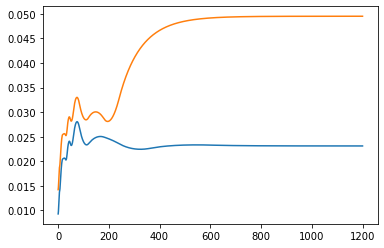

In [236]:
t = req['t']
spot_disc_asset = req['spot_disc_asset']
spot_disc_liab = req['spot_disc_liab']
forward_disc_asset = req['forward_disc_asset']
forward_disc_liab = req['forward_disc_liab']

plt.plot(t, forward_disc_asset)
plt.plot(t, forward_disc_liab)
plt.show()

In [249]:
with open('req.json', 'w') as f:
    json.dump(req, f)